### Importing libraries and dataset

In [ ]:
from scipy.io import loadmat
from glob import glob
import numpy as np
from numpy import array
import random

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization, Conv1D
from tensorflow.keras.utils import to_categorical

In [ ]:
# Only run this cell when IDE is google colab
# You can also download the dataset directly from here : https://www.kaggle.com/datasets/astrollama/cwru-case-western-reserve-university-dataset/data
!pip install keras-utils
!gdown 1XW87YiC9R2drRyU6IQybdMMWznZ_y-kk

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=742791f888ae73665e588d7b017f7f2816064af392089c8c18939e7b22b46ead
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils
Downloading...
From (original): https://drive.google.com/uc?id=1XW87YiC9R2drRyU6IQybdMMWznZ_y-kk
From (redirected): https://drive.google.com/uc?id=1XW87YiC9R2drRyU6IQybdMMWznZ_y-kk&confirm=t&uuid=001bf68a-de33-44eb-ac9c-ec8eb02b7e34
To: /content/data.zip
100% 45.2M/45.2M [00:01<00:00, 27.7MB/s]


In [ ]:
# Only run this cell when IDE is google colab
!unzip "/content/data.zip"
!mkdir -p checkpoints

Archive:  /content/data.zip
   creating: data/cwru/
  inflating: data/cwru/B007_0.mat    
  inflating: data/cwru/B007_1.mat    
  inflating: data/cwru/B007_2.mat    
  inflating: data/cwru/B007_3.mat    
  inflating: data/cwru/B014_0.mat    
  inflating: data/cwru/B014_1.mat    
  inflating: data/cwru/B014_2.mat    
  inflating: data/cwru/B014_3.mat    
  inflating: data/cwru/B021_0.mat    
  inflating: data/cwru/B021_1.mat    
  inflating: data/cwru/B021_2.mat    
  inflating: data/cwru/B021_3.mat    
 extracting: data/cwru/data.txt      
  inflating: data/cwru/IR007_0.mat   
  inflating: data/cwru/IR007_1.mat   
  inflating: data/cwru/IR007_2.mat   
  inflating: data/cwru/IR007_3.mat   
  inflating: data/cwru/IR014_0.mat   
  inflating: data/cwru/IR014_1.mat   
  inflating: data/cwru/IR014_2.mat   
  inflating: data/cwru/IR014_3.mat   
  inflating: data/cwru/IR021_0.mat   
  inflating: data/cwru/IR021_1.mat   
  inflating: data/cwru/IR021_2.mat   
  inflating: data/cwru/IR021_3.mat  

In [ ]:
# setting dev to GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



### Data Preparation

In [ ]:
# Change the directory to where the dataset is located and you also
# dont need to download or unzip files which you are using it in local machine
def get_cwru_lists(load, percentage, dir="/content/data/cwru/"):

  if percentage == "10%":
    lists = {0: dir + "Normal_" + str(load) + ".mat"}

  elif percentage =="20%":
    lists = {0: dir + "Normal_" + str(load) + ".mat",
             1: dir + "IR007_" + str(load) + ".mat"}

  elif percentage == "50%":
    lists = {0: dir + "Normal_" + str(load) + ".mat",
             1: dir + "IR007_" + str(load) + ".mat",
             2: dir + "IR014_" + str(load) + ".mat",
             3: dir + "IR021_" + str(load) + ".mat",
             4: dir + "B007_" + str(load) + ".mat"}
  else:
    lists = {0: dir + "Normal_" + str(load) + ".mat",
             1: dir + "IR007_" + str(load) + ".mat",
             2: dir + "IR014_" + str(load) + ".mat",
             3: dir + "IR021_" + str(load) + ".mat",
             4: dir + "B007_" + str(load) + ".mat",
             5: dir + "B014_" + str(load) + ".mat",
             6: dir + "B021_" + str(load) + ".mat",
             7: dir + "OR007@6_" + str(load) + ".mat",
             8: dir + "OR014@6_" + str(load) + ".mat",
             9: dir + "OR021@6_" + str(load) + ".mat"}

  return {label: glob(lists[label]) for label in lists}

def cwru_data(load, percentage, truncate=120000, length=1024, sample=200, shuffle=False):
  file_dirs = get_cwru_lists(load, percentage)

  out = []
  lbls = []

  for lbl in file_dirs:
    data = loadmat(file_dirs[lbl][0])
    for i in data:
      if "DE" in i:
        data = data[i][:truncate]
        data = [data[j:j + length] for j in range(0, len(data) - length + 1 , (len(data) - length)//(sample - 1) )] # sampling
        for k in range(0,len(data)):
          fft = abs(np.fft.fft(data[k])[:len(data[k])//2])
          out.append(fft)
          lbls.append([lbl])
      else:
        pass

  if percentage=="20%":
    out = out*5
    lbls = lbls*5

  if percentage=="10%":
    out = out*10
    lbls = lbls*10

  if percentage=="50%":
    out = out*2
    lbls = lbls*2

  if shuffle:
    random.seed(0)
    random.shuffle(out)
    random.seed(0)
    random.shuffle(lbls)

  lbls = to_categorical(array(lbls))
  return np.array(out), np.array(lbls)

def datagen(batch_size, src, tgt, percentage):
    src_data, src_labels = cwru_data(load=src, percentage="full", shuffle=True) # retrives the complete source data for training
    tgt_data, tgt_labels = cwru_data(load=tgt, percentage=percentage, shuffle=True)  # retrives choosen percentage of the target data for training
    tgt_data_full, tgt_labels_full = cwru_data(load=tgt, percentage="all")  # retrives all of the target data for testing
    # creating dataset
    src_data_gen = tf.data.Dataset.from_tensor_slices((src_data, src_labels))
    tgt_data_gen = tf.data.Dataset.from_tensor_slices((tgt_data, tgt_labels))
    tgt_data_gen_full = tf.data.Dataset.from_tensor_slices((tgt_data_full, tgt_labels_full))
    # creating data generators (full and half) for training and testing
    src_data_gen_f = src_data_gen.batch(batch_size=batch_size, drop_remainder=True)
    tgt_data_gen_f = tgt_data_gen.batch(batch_size=batch_size, drop_remainder=True)
    src_data_gen_h = src_data_gen.batch(batch_size=batch_size//2, drop_remainder=True) # for the feature extractor+discriminator combination, half of the data should be
    tgt_data_gen_h = tgt_data_gen.batch(batch_size=batch_size//2, drop_remainder=True) # from source and the other half from target
    tgt_data_gen_test = tgt_data_gen_full.batch(batch_size=1) # data generator for validation
    return tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data

In [ ]:
# Running this will check weather the choosen directory is properly functioning or not,
# It should give some output in the form of directory which means the directory is successfully mounted
l = get_cwru_lists(0, percentage="50%")
l

{0: ['/content/data/cwru/Normal_0.mat'],
 1: ['/content/data/cwru/IR007_0.mat'],
 2: ['/content/data/cwru/IR014_0.mat'],
 3: ['/content/data/cwru/IR021_0.mat'],
 4: ['/content/data/cwru/B007_0.mat']}

### Flip Gradient

In [ ]:
@tf.custom_gradient
def grad_reverse(x):
  y = tf.identity(x)
  def custom_grad(dy):
    return -dy
  return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

flip_grad = GradReverse()

### Model Generation

In [ ]:
def feature_extractor(inp):
  # Feature Extractor
  x = Conv1D(10, kernel_size=3, name='f_conv1', input_shape= (512,1))(inp)
  x = Dropout(0.5)(x)
  x = Conv1D(10, kernel_size=3, name='f_conv2')(x)
  x = Dropout(0.5)(x)
  x = Conv1D(10, kernel_size=3, name='f_conv3')(x)
  x = Dropout(0.5)(x)
  x = Flatten(name="f_flat")(x)
  features_s2 = Dense(256, activation=tf.nn.sigmoid, name="f_fc")(x)
  return features_s2

def classifier(features_s2):
  # Classifier
  out = Dense(256, activation=tf.nn.relu, name="clf_fc1")(features_s2)
  out = Dropout(0.5)(out)
  out_classf = Dense(10, name="clf_fc")(out)
  return out_classf

def discriminator(flipg):
  # Discriminator
  dom = Dense(1024, activation=tf.nn.relu, name="dis_fc1")(flipg)
  dom = Dense(1024, activation=tf.nn.relu, name="dis_fc2")(dom)
  out_disc = Dense(2, name="dis_fc")(dom)
  return out_disc

def danU_model(input_shape):
  inp = Input(input_shape)
  features_s2 = feature_extractor(inp)
  out_classf = classifier(features_s2)
  flipg = flip_grad(features_s2)
  out_disc = discriminator(flipg)
  model_s2 = Model(inp, [out_classf, out_disc])
  return model_s2

def featExt_s1():
  h = Sequential()
  h.add(Conv1D(10, kernel_size=3, name='conv_1', input_shape= (512,1)))
  h.add(Dropout(0.5))
  h.add(Conv1D(10, kernel_size=3, name='conv_2'))
  h.add(Dropout(0.5))
  h.add(Conv1D(10, kernel_size=3, name='conv_3'))
  h.add(Dropout(0.5))
  h.add(Flatten())
  h.add(Dense(256, activation=tf.nn.sigmoid))
  return h

In [ ]:
input_shape = (512,1)
model_s1 = featExt_s1()
model_s1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_s1_FExt = Model(model_s1.input, model_s1.layers[-1].output)

model_s2 = danU_model(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### Model Arch

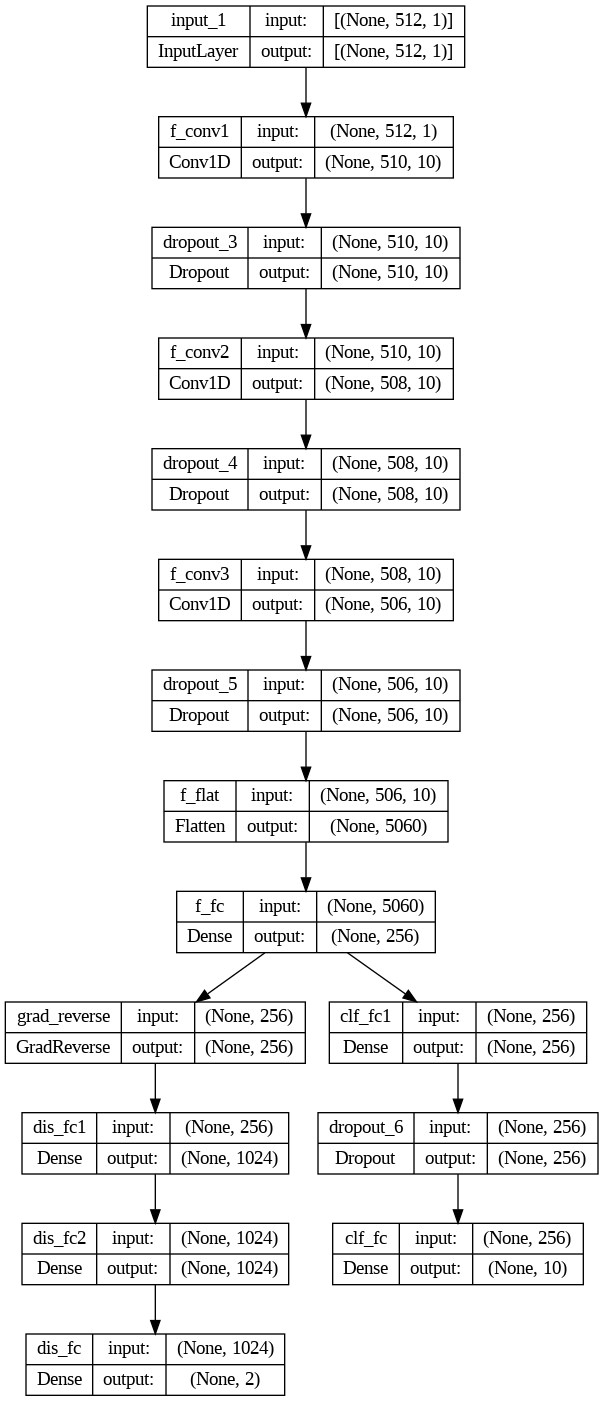

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_s2, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

### Training Session

In [ ]:
def training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data):
  tr_accu =[]
  tr_loss = []
  val_loss=[]
  for epoch in range(epochs):
    # training performance metrics init
    tr_accu =[]
    tr_loss = []
    val_loss=[]
    val_acc=[]
    print("\nEpoch:", epoch+1,'/',epochs)
    for step, (src_f, src_h, tgt_h) in enumerate(zip(src_data_gen_f, src_data_gen_h, tgt_data_gen_h)):
      with tf.GradientTape() as tape:
        # classification and loss
        out_classf,_ = model_s2(src_f[0], training=True)
        loss_clf = tf.nn.softmax_cross_entropy_with_logits(labels=src_f[1], logits=out_classf)

        # consistency loss from feature maps of inputs from model_s1 and model_s2
        model_s2_FExt = Model(model_s2.input, model_s2.layers[8].output)
        feat_s2 = model_s2_FExt(src_f[0], training=False)
        feat_s1 = model_s1_FExt(src_f[0], training=False)
        loss_cons = np.sum(np.abs((feat_s1-feat_s2)), axis=1)/len(feat_s1[0])

        # loss of discriminator
        pair = tf.concat([src_h[0],tgt_h[0]],0)
        dom_lbl = np.vstack(([[1.,0.]]*(batch_size//2), [[0.,1.]]*(batch_size//2)))
        _,out_disc = model_s2(pair, training=True)
        loss_d = tf.nn.softmax_cross_entropy_with_logits(labels=dom_lbl, logits=out_disc)

        l = 1 #lambda (regularisation term for the consistency loss)
        loss_value = loss_clf + loss_d + l*loss_cons  # total loss

      grads = tape.gradient(loss_value, model_s2.trainable_weights)
      optimizer.apply_gradients(zip(grads, model_s2.trainable_weights))
      tr_accu.append(tf.metrics.CategoricalAccuracy()(src_f[1], tf.nn.softmax(out_classf)))  # update training metric.
      tr_loss.append(np.average(loss_value))  # update training loss
      tf.keras.utils.Progbar(len(src_data)//batch_size).update(step+1)  #updates prog bar

    # validation
    val_lbls=[]
    val_output=[]
    val_loss=[]
    for i, dat in enumerate(tgt_data_gen_test):
      out,_ = model_s2(dat[0], training=False)
      val_loss.append(tf.nn.softmax_cross_entropy_with_logits(labels=dat[1], logits=out))
      val_lbls.append(dat[1])
      val_output.append(out)

    val_accu = tf.metrics.CategoricalAccuracy()(val_lbls, tf.nn.softmax(val_output))    # validation accuracy
    val_acc
    print("Training accuracy:", np.average(tr_accu), " Training loss:", np.average(tr_loss), " Validation accuracy:", val_accu.numpy(), " Validation loss:", np.average(val_loss))
  return np.average(tr_accu), np.average(tr_loss), val_accu.numpy(), np.average(val_loss)

### Training for all tasks

In [ ]:
tacc_accumulator = []
tloss_accumulator = []
vacc_accumulator = []
vloss_accumulator = []

#### TASK : |src : 0 ---> tgt : 0, 1, 2, 3|

In [ ]:
src = 0
tgt = 0
epochs = 200
batch_size = 64
percentage = "10%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)

In [ ]:
src = 0
tgt = 1
epochs = 200
batch_size = 64
percentage = "10%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8361895  Training loss: 1.2239877  Validation accuracy: 0.6995  Validation loss: 1.0537403

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8210685  Training loss: 1.217943  Validation accuracy: 0.632  Validation loss: 1.3692676

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.82308465  Training loss: 1.317691  Validation accuracy: 0.6975  Validation loss: 1.261785

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8185484  Training loss: 1.232253  Validation accuracy: 0.6695  Validation loss: 1.1758761

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8301411  Training loss: 1.2361789  Validation accuracy: 0.678  Validation loss: 1.2997576

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8251008  Trainin

In [ ]:
src = 0
tgt = 2
epochs = 200
batch_size = 64
percentage = "50%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7580645  Training loss: 4.073706  Validation accuracy: 0.734  Validation loss: 0.7155938

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76814514  Training loss: 1.8489867  Validation accuracy: 0.753  Validation loss: 0.6874336

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7752016  Training loss: 1.7575291  Validation accuracy: 0.7395  Validation loss: 0.7021545

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.77116936  Training loss: 1.7564689  Validation accuracy: 0.741  Validation loss: 0.6927546

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.77116936  Training loss: 1.7882718  Validation accuracy: 0.7505  Validation loss: 0.6825805

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7888105  Tra

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 0
tgt = 3
epochs = 200
batch_size = 64
percentage = "20%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7580645  Training loss: 2.1929388  Validation accuracy: 0.8895  Validation loss: 0.34349975

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7575605  Training loss: 1.9781505  Validation accuracy: 0.922  Validation loss: 0.25500455

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76310486  Training loss: 1.959623  Validation accuracy: 0.9005  Validation loss: 0.3272005

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.718246  Training loss: 2.112243  Validation accuracy: 0.875  Validation loss: 0.42318383

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7454637  Training loss: 1.9702152  Validation accuracy: 0.906  Validation loss: 0.3248798

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.75352824  Tra

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

#### TASK : |src : 1 ---> tgt : 0, 1, 2, 3|

In [ ]:
src = 1
tgt = 0
epochs = 200
batch_size = 64
percentage = "50%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76058465  Training loss: 1.9239224  Validation accuracy: 0.773  Validation loss: 0.6581894

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.75554436  Training loss: 1.891581  Validation accuracy: 0.8125  Validation loss: 0.5164186

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7736895  Training loss: 1.7818613  Validation accuracy: 0.9205  Validation loss: 0.25410265

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76310486  Training loss: 1.7806233  Validation accuracy: 0.921  Validation loss: 0.26519403

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7883065  Training loss: 1.7270033  Validation accuracy: 0.8995  Validation loss: 0.31878802

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7731855 

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 1
tgt = 1
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8639113  Training loss: 1.6310107  Validation accuracy: 0.9125  Validation loss: 0.24287172

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.85584676  Training loss: 1.6184822  Validation accuracy: 0.936  Validation loss: 0.20550688

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8654234  Training loss: 1.599662  Validation accuracy: 0.94  Validation loss: 0.18809767

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.874496  Training loss: 1.5749016  Validation accuracy: 0.941  Validation loss: 0.18122248

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8815524  Training loss: 1.5596336  Validation accuracy: 0.9315  Validation loss: 0.19865057

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8815524  Tr

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 1
tgt = 2
epochs = 200
batch_size = 64
percentage = "10%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.41834676  Training loss: 29.864895  Validation accuracy: 0.4765  Validation loss: 9.035082

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.45060483  Training loss: 2.8349512  Validation accuracy: 0.4805  Validation loss: 8.80604

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.5080645  Training loss: 2.346512  Validation accuracy: 0.569  Validation loss: 9.049286

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.515625  Training loss: 2.0824835  Validation accuracy: 0.5955  Validation loss: 8.892901

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.5388105  Training loss: 2.0312102  Validation accuracy: 0.583  Validation loss: 9.027846

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.5252016  Training l

In [ ]:
src = 1
tgt = 3
epochs = 200
batch_size = 64
percentage = "10%"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.6189516  Training loss: 13.5463085  Validation accuracy: 0.6605  Validation loss: 1.1070578

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.6809476  Training loss: 1.6384599  Validation accuracy: 0.7265  Validation loss: 0.8955051

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7298387  Training loss: 1.4286507  Validation accuracy: 0.742  Validation loss: 0.8692528

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7721774  Training loss: 1.3394426  Validation accuracy: 0.745  Validation loss: 0.8699404

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7792339  Training loss: 1.3096455  Validation accuracy: 0.7615  Validation loss: 0.8420024

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.7701613  Tra

#### TASK : |src : 2 ---> tgt : 0, 1, 2, 3|

In [ ]:
src = 2
tgt = 0
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.79939514  Training loss: 1.9295106  Validation accuracy: 0.8225  Validation loss: 0.5963546

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.80241936  Training loss: 1.8383522  Validation accuracy: 0.8275  Validation loss: 0.5355624

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8135081  Training loss: 1.811952  Validation accuracy: 0.8175  Validation loss: 0.5516071

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8215726  Training loss: 1.8149041  Validation accuracy: 0.8145  Validation loss: 0.59162354

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.83366936  Training loss: 1.7571669  Validation accuracy: 0.8085  Validation loss: 0.6505365

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8311492 

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 2
tgt = 1
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.92691535  Training loss: 1.4574474  Validation accuracy: 0.9155  Validation loss: 0.35883546

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9344758  Training loss: 1.4316262  Validation accuracy: 0.902  Validation loss: 0.3909591

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9248992  Training loss: 1.4429158  Validation accuracy: 0.8935  Validation loss: 0.45022434

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9107863  Training loss: 1.4442222  Validation accuracy: 0.913  Validation loss: 0.3572694

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.922379  Training loss: 1.4446111  Validation accuracy: 0.901  Validation loss: 0.38018668

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.92540324  T

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 2
tgt = 2
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9359879  Training loss: 1.4180948  Validation accuracy: 0.994  Validation loss: 0.036521897

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9470766  Training loss: 1.371735  Validation accuracy: 0.9925  Validation loss: 0.03543992

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.95060486  Training loss: 1.3774413  Validation accuracy: 0.991  Validation loss: 0.039497156

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9450605  Training loss: 1.3729539  Validation accuracy: 0.992  Validation loss: 0.03627624

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9435484  Training loss: 1.3728744  Validation accuracy: 0.9935  Validation loss: 0.035577506

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.953629

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 2
tgt = 3
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.952621  Training loss: 1.3474535  Validation accuracy: 0.808  Validation loss: 1.0866894

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.952621  Training loss: 1.3360041  Validation accuracy: 0.8165  Validation loss: 1.0340967

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9516129  Training loss: 1.3372537  Validation accuracy: 0.817  Validation loss: 0.8625021

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9596774  Training loss: 1.3168756  Validation accuracy: 0.825  Validation loss: 0.9203165

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.96471775  Training loss: 1.3150902  Validation accuracy: 0.821  Validation loss: 0.961831

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9551411  Training

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

#### TASK : |src : 3 ---> tgt : 0, 1, 2, 3|

In [ ]:
src = 3
tgt = 0
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.69304436  Training loss: 2.266135  Validation accuracy: 0.7525  Validation loss: 0.7558359

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.72127014  Training loss: 2.0633328  Validation accuracy: 0.7635  Validation loss: 0.774288

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.75554436  Training loss: 1.9814581  Validation accuracy: 0.777  Validation loss: 0.7960932

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76008064  Training loss: 1.9617494  Validation accuracy: 0.8075  Validation loss: 0.8662737

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76209676  Training loss: 1.9362891  Validation accuracy: 0.7955  Validation loss: 0.79617846

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.76058465

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 3
tgt = 1
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8765121  Training loss: 1.5163468  Validation accuracy: 0.843  Validation loss: 0.599924

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8654234  Training loss: 1.5414232  Validation accuracy: 0.875  Validation loss: 0.6365578

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.85383064  Training loss: 1.5994596  Validation accuracy: 0.8505  Validation loss: 0.6308317

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.87247986  Training loss: 1.5288762  Validation accuracy: 0.8505  Validation loss: 0.6258191

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.86995965  Training loss: 1.5359591  Validation accuracy: 0.85  Validation loss: 0.65493727

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8719758  Tra

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 3
tgt = 2
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9032258  Training loss: 1.4982903  Validation accuracy: 0.9115  Validation loss: 0.31236547

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.90977824  Training loss: 1.4575297  Validation accuracy: 0.9095  Validation loss: 0.3077863

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9188508  Training loss: 1.4128324  Validation accuracy: 0.925  Validation loss: 0.26726806

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9138105  Training loss: 1.4518323  Validation accuracy: 0.9175  Validation loss: 0.24852999

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.8916331  Training loss: 1.4972582  Validation accuracy: 0.9145  Validation loss: 0.3150884

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.91179436

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

In [ ]:
src = 3
tgt = 3
epochs = 200
batch_size = 64
percentage = "full"

tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data = datagen(batch_size, src, tgt, percentage)
t_acc, t_loss, v_acc, v_loss = training(epochs, batch_size, tgt_data_gen_test, tgt_data_gen_h, src_data_gen_h, src_data_gen_f, src_data)
tacc_accumulator.append(t_acc)
tloss_accumulator.append(t_loss)
vacc_accumulator.append(v_acc)
vloss_accumulator.append(v_loss)


Epoch: 1 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.92439514  Training loss: 1.3994147  Validation accuracy: 0.981  Validation loss: 0.06915604

Epoch: 2 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9309476  Training loss: 1.4041061  Validation accuracy: 0.981  Validation loss: 0.06489492

Epoch: 3 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9304435  Training loss: 1.397541  Validation accuracy: 0.972  Validation loss: 0.07007685

Epoch: 4 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.936996  Training loss: 1.385559  Validation accuracy: 0.979  Validation loss: 0.063777484

Epoch: 5 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9198589  Training loss: 1.417813  Validation accuracy: 0.981  Validation loss: 0.06395934

Epoch: 6 / 200
31/31 [==============================] - 0s 0s/step
Training accuracy: 0.9299395  Trai

'tacc_accumulator.append(t_acc)\ntloss_accumulator.append(t_loss)\nvacc_accumulator.append(v_acc)\nvloss_accumulator.append(v_loss)'

### Summary

In [ ]:
from tabulate import tabulate

name_list = ["Task 0--->0", "Task 0--->1", "Task 0--->2", "Task 0--->3", "Task 1--->0", "Task 1--->1", "Task 1--->2", "Task 1--->3", "Task 2--->0", "Task 2--->1", "Task 2--->2", "Task 2--->3", "Task 3--->0", "Task 3--->1", "Task 3--->2", "Task 3--->3"]
data = [name_list, [round(x, 2) * 100 for x in tacc_accumulator], [round(x, 3) for x in tloss_accumulator]]
data = list(zip(*data))
headers = ["Name", "Accuracy", "Loss"]
print(tabulate(data, headers, tablefmt="pretty"))

+-------------+----------+-------+
|    Name     | Accuracy | Loss  |
+-------------+----------+-------+
| Task 0--->0 |   83.0   | 1.224 |
| Task 0--->1 |   98.0   | 0.907 |
| Task 0--->2 |   85.0   | 1.479 |
| Task 0--->3 |   87.0   | 1.559 |
| Task 1--->0 |   86.0   | 1.499 |
| Task 1--->1 |   91.0   | 1.461 |
| Task 1--->2 |   90.0   | 1.023 |
| Task 1--->3 |   95.0   | 0.899 |
| Task 2--->0 |   92.0   | 1.473 |
| Task 2--->1 |   93.0   | 1.402 |
| Task 2--->2 |   94.0   | 1.391 |
| Task 2--->3 |   97.0   | 1.304 |
| Task 3--->0 |   86.0   | 1.528 |
| Task 3--->1 |   91.0   | 1.428 |
| Task 3--->2 |   93.0   | 1.388 |
| Task 3--->3 |   94.0   | 1.373 |
+-------------+----------+-------+


### Logging

In [ ]:
import datetime

now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H:%M:%S")

with open(r"G:\DAN\Codes\dxda-master\dxda-master\table.log", "w") as f:
  f.write(tabulate(data, headers, tablefmt="pretty"))
  f.write("\n\nDate and Time: {}\n".format(date_time))
  f.close()